In [1]:
from pathlib import Path
import pandas as pd
from bitis.texture.analysis import ObjectAnalysis

import numpy as np
from skimage import io


class ImageParser:
    def __init__(self):
        pass

    @staticmethod
    def read_png(path):
        image = io.imread(path, as_gray=True)
        return np.add(image < 0.4, image < 0.8, dtype=int)

    @staticmethod
    def write_png(image, path):
        fib = [153, 1, 2]
        myo = [226, 168, 88]

        out_image = np.zeros((image.shape[0], image.shape[1], 3),
                             dtype=np.uint8)
        out_image[image == 1] = myo
        out_image[image == 2] = fib
        io.imsave(path, out_image)


def calc_props(image):
    object_analysis = ObjectAnalysis()
    object_props = object_analysis.build_props(image == 2, area_min=1)
    return object_props


def read_image(path):
    image = ImageParser.read_png(path)
    image[image == 0] = 1
    return image[:100, :100]


def make_pattern_stats(path, pattern_ids, n_samples=100):
    
    all_pattern_props = []
    all_object_props = []
    for pattern_id in pattern_ids:
        for i in range(n_samples):
            image = read_image(path.joinpath(f'simulated_{pattern_id}',
                                             f'gen_tex_{pattern_id}_{i}.png'))
            
            object_props = calc_props(image)
            object_props['pattern_id'] = pattern_id
            object_props['sample_id'] = i

            all_object_props.append(object_props)
    
    all_object_props = pd.concat(all_object_props).reset_index(drop=True)
    return all_object_props

In [3]:
# path = Path('/home/arstan/Projects/Fibrosis/BiTis/data')
path = Path('/Users/arstanbek/Projects/Fibrosis/BiTis/data')

pattern_ids = [25, 2, 34, 5]
data = make_pattern_stats(path, pattern_ids)
data['orientation'] = np.degrees(data['orientation'])

### Load Training and Uniform Generator data

In [4]:
from tqdm import tqdm

uni_data = []
tr_data = []

for pattern_id in pattern_ids:
    tr_image = read_image(path.joinpath('training',
                                        f'or_tex_{pattern_id}.png'))
    oprops = calc_props(tr_image)
    oprops['pattern_id'] = pattern_id
    oprops['sample_id'] = 0
    tr_data.append(oprops)
    dens = np.mean(tr_image == 2)
    
    for i in tqdm(range(100)):
        # Generate uniform image
        uni_image = 1 + (np.random.random(tr_image.shape) <= dens).astype(int)
        oprops = calc_props(uni_image)
        oprops['pattern_id'] = pattern_id
        oprops['sample_id'] = i

        uni_data.append(oprops)


tr_data = pd.concat(tr_data).reset_index(drop=True)
tr_data['orientation'] = np.degrees(tr_data['orientation'])

uni_data = pd.concat(uni_data).reset_index(drop=True)
uni_data['orientation'] = np.degrees(uni_data['orientation'])

100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


In [5]:
def correct_orientation(data, p_id, base_orient):
    mask = (data['pattern_id'] == p_id) & (data['orientation'] > base_orient + 90)
    data.loc[mask , 'orientation'] = data.loc[mask, 'orientation'] - 180
    mask = (data['pattern_id'] == p_id) & (data['orientation'] < base_orient - 90)
    data.loc[mask , 'orientation'] = data.loc[mask, 'orientation'] + 180
    return data

In [6]:
data_all = []

data['source'] = 'ds'
tr_data['source'] = 'tr'
uni_data['source'] = 'uni'

# data_all = data_all[data_all['area'] > 10]

for p_id, base_orient in zip([25, 2, 34, 5], [-28, 76, -49, 50]):
    data_ = correct_orientation(data.copy(), p_id, base_orient)
    tr_data_ = correct_orientation(tr_data.copy(), p_id, base_orient)
    data_all += [data_, tr_data_, uni_data]

data_all = pd.concat(data_all).reset_index(drop=True)
data_all['source'] = data_all['source'].astype('category')

In [9]:
columns = ['source', 'pattern_id', 'axis_ratio', 'orientation',
           'solidity']

data_all_10 = data_all[data_all['area'] > 10]
res = data_all_10[columns].groupby(['source', 'pattern_id']).describe().T
res.sort_index(axis=1, level=1, inplace=True)

r = res.loc['solidity', '50%'].round(2).reset_index()
r['pattern_id'] = r['pattern_id'].map({v: k+1 for k, v in enumerate(pattern_ids)})
r.T

/var/folders/g1/w2ks7h117tx5hyrc51qld9v80000gn/T/ipykernel_1502/3446500667.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res = data_all_10[columns].groupby(['source', 'pattern_id']).describe().T


,,0,1,2,3,4,5,6,7,8,9,10,11
source,,ds,tr,uni,ds,tr,uni,ds,tr,uni,ds,tr,uni
pattern_id,,2,2,2,4,4,4,1,1,1,3,3,3
solidity,50%,0.75,0.75,0.68,0.66,0.63,0.64,0.72,0.71,0.67,0.75,0.75,0.66


In [12]:
def calc_ccdf(df):
    count = np.bincount(df['area'].to_numpy(dtype=int))
    area_bins = np.arange(1 + df['area'].max())

    area_bins = area_bins[1:]
    count = count[1:]
    ccdf = np.cumsum(count[::-1])[::-1] / np.sum(count)
    return area_bins, ccdf


def calc_area_cdf(df):
    count = np.bincount(df['area'].values)
    area_bins = np.arange(1 + df['area'].max())

    area_bins = area_bins[1:]
    count = count[1:]
    area = area_bins * count

    cdf = np.cumsum(area) / np.sum(area)
    return area_bins, cdf


def draw_area_cdf(ax, objects_props, label='', color='blue', alpha=1.0):
    area_bins, cdf = calc_area_cdf(objects_props)
    ax.plot(area_bins, cdf, label=label, color=color, alpha=alpha)
    ax.set_xlabel('Cluster Size', fontsize=10)
    ax.set_ylabel('Fibrotic Tissue', fontsize=10)
    ax.set_xscale('log')


def draw_ccdf(ax, objects_props, label='', color='blue', alpha=1.0):
    area_bins, ccdf = calc_ccdf(objects_props)
    ax.plot(area_bins, ccdf, label=label, color=color, alpha=alpha)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid(True, which='both', alpha=0.5)

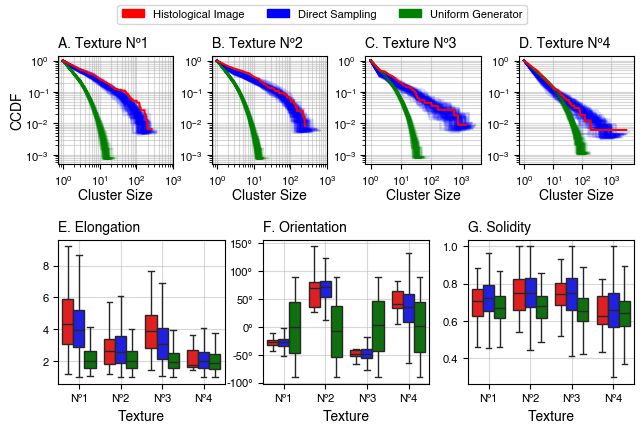

In [47]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rc('font', family='Helvetica', size=8)


fig, axs = plt.subplot_mosaic([['a'] * 3 + ['b'] * 3 + ['c'] * 3 + ['d'] * 3,
                               ['e'] * 4 + ['f'] * 4 + ['g'] * 4],
                                figsize=(6.4, 4),
                                height_ratios=[3, 4])

# Draw area CCDF
for i, (pattern_id, subplot) in enumerate(zip(pattern_ids,
                                              ['a', 'b', 'c', 'd'])):
    ax = axs[subplot]
    for j in range(100):
        mask = ((data['pattern_id'] == pattern_id)
                & (data['sample_id'] == j))
        draw_ccdf(ax, data[mask], color='blue', alpha=0.15)

        mask = ((uni_data['pattern_id'] == pattern_id)
                & (uni_data['sample_id'] == j))
        draw_ccdf(ax, uni_data[mask], color='green', alpha=0.15)

    # draw_ccdf(ax, data[data['pattern_id'] == pattern_id],
    #           color='blue', alpha=1.0)
    draw_ccdf(ax, tr_data[tr_data['pattern_id'] == pattern_id],
              color='red', alpha=1.0)
    # draw_ccdf(ax, uni_data[uni_data['pattern_id'] == pattern_id],
    #           color='g', alpha=1.0)


for subplot, prop_name in zip(['e', 'f', 'g'],
                              ['axis_ratio', 'orientation', 'solidity']):
    ax = axs[subplot]
    sns.boxplot(x='pattern_id', y=prop_name, data=data_all_10,
                order=pattern_ids, ax=ax, linewidth=1, hue='source',
                hue_order=['tr', 'ds', 'uni'],
                palette=['red', 'blue', 'green'], legend=False,
                showfliers=False)

#
for i, subplot in enumerate(['a', 'b', 'c', 'd']):
    ax = axs[subplot]
    ax.set_xlabel('Cluster Size', fontsize=10, labelpad=1)
    ax.set_title(f'{subplot.upper()}. Texture Nº{i+1}', fontsize=10,
                 loc='left')
    ax.set_xticks([1, 10, 100, 1000,])
    ax.grid(True, which='both', alpha=0.5)
    ax.sharey(axs['a'])

axs['a'].set_ylabel('CCDF', fontsize=10, labelpad=1)

for subplot, title in zip(['e', 'f', 'g'],
                          ['Elongation', 'Orientation', 'Solidity']):
    ax = axs[subplot]
    ax.set_xticks(np.arange(len(pattern_ids)))
    ax.set_xticklabels([f'Nº{i}' for i in range(1, 1 + len(pattern_ids))],
                           fontsize=8)
    ax.set_xlabel('Texture', fontsize=10)
    ax.set_title(f'{subplot.upper()}. {title}', fontsize=10, loc='left')
    # ax.set_ylabel(title, fontsize=10, labelpad=1)
    ax.set_ylabel('')
    ax.grid(True, which='both', alpha=0.5)

# axs['f'].set_ylim(-90, 90)
# axs['f'].set_yticks(np.linspace(-90, 90, 7))
axs['f'].yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, _: f'{x:.0f}°'))

for k, v in axs.items():
    v.tick_params(axis='both', which='major', labelsize=8)

legend_patches = [mpatches.Patch(facecolor='red', edgecolor='red',
                                    linewidth=1, label='Histological Image'),
                    mpatches.Patch(facecolor='blue', edgecolor='blue',
                                    linewidth=1, label='Direct Sampling'),
                    mpatches.Patch(facecolor='green', edgecolor='green',
                                    linewidth=1, label='Uniform Generator')]
fig.legend(handles=legend_patches, loc='upper center', ncol=3, prop={'size': 8})
# plt.tight_layout(rect=[0, 0, 1, 0.93], h_pad=0.2, w_pad=0.2)
plt.subplots_adjust(top=0.87, bottom=0.05, left=0.05, right=0.95, hspace=0.6,
                    wspace=3)
plt.show()


In [49]:
path_save = Path('/Users/arstanbek/Projects/fibrosis/FibrosisAnalysis/paperfigures/pdffig')
fig.savefig(path_save.joinpath('Figure12.pdf'),
            format='pdf',
            dpi=1000,
            bbox_inches='tight')

In [31]:

columns = ['source', 'pattern_id', 'sample_id', 'axis_ratio', 'orientation',
           'solidity']
data_stats = data_all_10[columns].groupby(
    ['source', 'pattern_id', 'sample_id']).describe().reset_index()
data_stats.head()


/var/folders/g1/w2ks7h117tx5hyrc51qld9v80000gn/T/ipykernel_1502/1797070351.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_stats = data_all_10[columns].groupby(


source pattern_id sample_id axis_ratio                                \
                                   count      mean       std       min   
0     ds          2         0      140.0  2.697366  1.256827  1.017345   
1     ds          2         1      156.0  2.933277  1.063390  1.105531   
2     ds          2         2      136.0  3.014103  1.502583  1.109721   
3     ds          2         3      148.0  2.819221  1.247438  1.057043   
4     ds          2         4      148.0  3.125698  1.146227  1.394360   

                                 ... orientation             solidity  \
        25%       50%       75%  ...         75%         max    count   
0  1.873127  2.344429  3.230715  ...   85.058561  145.251971    140.0   
1  2.212204  2.961595  3.379000  ...   84.874333  159.006394    156.0   
2  1.879215  2.479483  3.791311  ...   82.695767  130.375617    136.0   
3  1.918412  2.619927  3.128204  ...   85.268839  151.097867    148.0   
4  2.112581  3.033819  3.820576  ...   84.067660  125.613513    148.0   

                                                                         
       mean       std       min       25%       50%       75%       max  
0  0.769129  0.106458  0.567010  0.702247  0.763948  0.833333  1.000000  
1  0.726890  0.109508  0.468310  0.666667  0.761905  0.800000  0.944444  
2  0.719334  0.099038  0.501235  0.649770  0.739111  0.774194  0.961538  
3  0.740715  0.112922  0.482301  0.671429  0.734043  0.808824  0.947368  
4  0.721177  0.095118  0.542683  0.666667  0.711111  0.785714  0.923077  

[5 rows x 27 columns]

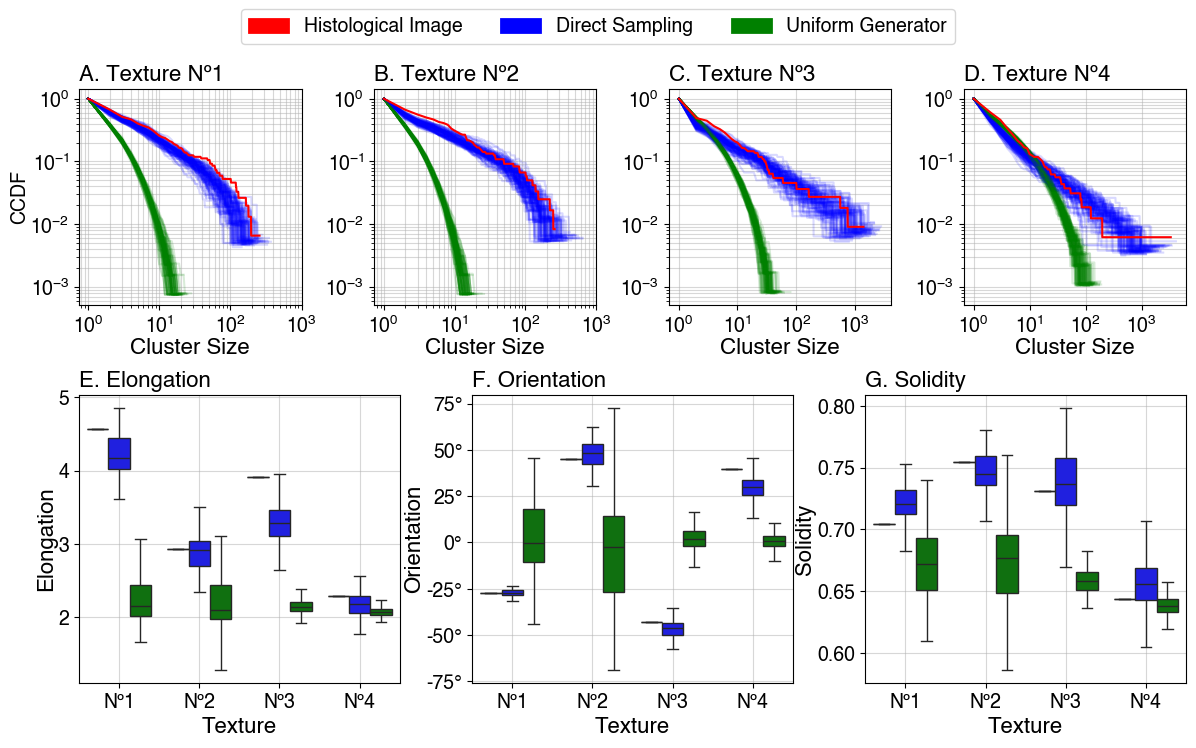

In [32]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rc('font', family='Helvetica')


fig, axs = plt.subplot_mosaic([['a'] * 3 + ['b'] * 3 + ['c'] * 3 + ['d'] * 3,
                               ['e'] * 4 + ['f'] * 4 + ['g'] * 4],
                                figsize=(12, 7.5),
                                height_ratios=[3, 4])

# Draw area CCDF
for i, (pattern_id, subplot) in enumerate(zip(pattern_ids,
                                              ['a', 'b', 'c', 'd'])):
    ax = axs[subplot]
    for j in range(100):
        mask = ((data['pattern_id'] == pattern_id)
                & (data['sample_id'] == j))
        draw_ccdf(ax, data[mask], color='blue', alpha=0.15)

        mask = ((uni_data['pattern_id'] == pattern_id)
                & (uni_data['sample_id'] == j))
        draw_ccdf(ax, uni_data[mask], color='green', alpha=0.15)

    # draw_ccdf(ax, data[data['pattern_id'] == pattern_id],
    #           color='blue', alpha=1.0)
    draw_ccdf(ax, tr_data[tr_data['pattern_id'] == pattern_id],
              color='red', alpha=1.0)
    # draw_ccdf(ax, uni_data[uni_data['pattern_id'] == pattern_id],
    #           color='g', alpha=1.0)


for subplot, prop_name in zip(['e', 'f', 'g'],
                              ['axis_ratio', 'orientation', 'solidity']):
    ax = axs[subplot]
    sns.boxplot(x='pattern_id', y=(prop_name, 'mean'), data=data_stats,
                order=pattern_ids, ax=ax, linewidth=1, hue='source',
                hue_order=['tr', 'ds', 'uni'],
                palette=['red', 'blue', 'green'], legend=False,
                showfliers=False)

#
for i, subplot in enumerate(['a', 'b', 'c', 'd']):
    ax = axs[subplot]
    ax.set_xlabel('Cluster Size', fontsize=16, labelpad=1)
    ax.set_title(f'{subplot.upper()}. Texture Nº{i+1}', fontsize=16,
                 loc='left')
    ax.set_xticks([1, 10, 100, 1000,])
    ax.grid(True, which='both', alpha=0.5)
    ax.sharey(axs['a'])

axs['a'].set_ylabel('CCDF', fontsize=14, labelpad=1)

for subplot, title in zip(['e', 'f', 'g'],
                          ['Elongation', 'Orientation', 'Solidity']):
    ax = axs[subplot]
    ax.set_xticks(np.arange(len(pattern_ids)))
    ax.set_xticklabels([f'Nº{i}' for i in range(1, 1 + len(pattern_ids))],
                           fontsize=14)
    ax.set_xlabel('Texture', fontsize=16)
    ax.set_title(f'{subplot.upper()}. {title}', fontsize=16, loc='left')
    ax.set_ylabel(title, fontsize=16, labelpad=1)
    ax.grid(True, which='both', alpha=0.5)

# axs['f'].set_ylim(-90, 90)
# axs['f'].set_yticks(np.linspace(-90, 90, 7))
axs['f'].yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, _: f'{x:.0f}°'))

for k, v in axs.items():
    v.tick_params(axis='both', which='major', labelsize=14)

legend_patches = [mpatches.Patch(facecolor='red', edgecolor='red',
                                    linewidth=2, label='Histological Image'),
                    mpatches.Patch(facecolor='blue', edgecolor='blue',
                                    linewidth=2, label='Direct Sampling'),
                    mpatches.Patch(facecolor='green', edgecolor='green',
                                    linewidth=2, label='Uniform Generator')]
fig.legend(handles=legend_patches, loc='upper center', ncol=3, prop={'size': 14})
plt.tight_layout(rect=[0, 0, 1, 0.93], h_pad=1, w_pad=0.2)
plt.show()
